# Telco Customer Churn

Objetivo: prever se o cliente vai cancelar (Churn = Yes) ou não (Churn = No).

Fluxo:
1) EDA básica (distribuição do churn, nulos, relações simples)
2) Pré-processamento (OneHotEncoder p/ categóricas, StandardScaler p/ numéricas)
3) Split estratificado (train/test)
4) Balanceamento com SMOTE (dados desbalanceados)
5) Modelos: Logistic Regression (baseline) e Random Forest (comparativo)
6) Avaliação: classification_report, confusion_matrix, ROC AUC


## Importação de Bibliotecas

In [37]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.model_selection import train_test_split  
from sklearn.compose import ColumnTransformer  
from sklearn.preprocessing import OneHotEncoder, StandardScaler 

from sklearn.impute import SimpleImputer  
from sklearn.pipeline import Pipeline  
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score  
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier  

from imblearn.over_sampling import SMOTE  

# Configurações visuais e de reprodutibilidade
RANDOM_STATE = 42  
np.random.seed(RANDOM_STATE)
sns.set(font_scale=1.0) 
plt.rcParams["figure.figsize"] = (7, 4)  


## Carregando Arquivo

In [38]:
DATA_PATH = r"C:\Users\marcu\Desktop\PROJECT-CustomChurn\Telco Custom Dataset\WA_Fn-UseC_-Telco-Customer-Churn.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Não encontrei o arquivo em: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Limpeza mínima e alvo

In [39]:
df = df.copy()
df.columns = [c.strip() for c in df.columns]

if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan), errors="coerce")

for id_col in ("customerID", "CustomerID", "id"):
    if id_col in df.columns:
        df.drop(columns=[id_col], inplace=True)

if "Churn" not in df.columns:
    raise KeyError("Coluna 'Churn' não encontrada no dataset.")
y = (df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

X = df.drop(columns=["Churn"])
X.shape, y.mean()


((7043, 19), np.float64(0.2653698707936959))

## AED: distribuição e nulos

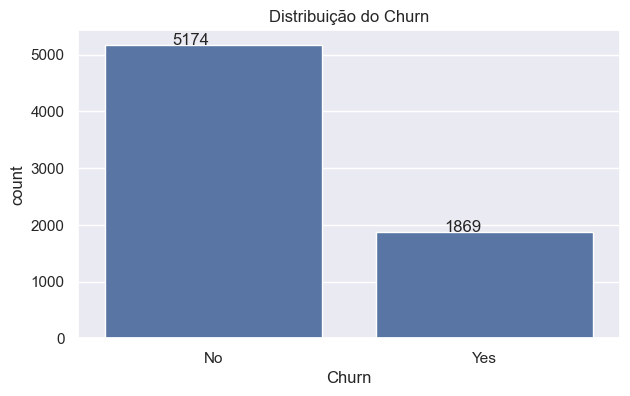

Proporção de churn (1): 0.2654


TotalCharges    0.001562
dtype: float64

In [40]:
ax = sns.countplot(x=y.map({0:"No", 1:"Yes"}))
ax.set_title("Distribuição do Churn")
ax.set_xlabel("Churn")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+3))
plt.show()

print("Proporção de churn (1):", y.mean().round(4))

missing = X.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(15)


## AED: relação simples cat vs churn

Categóricas: 15 | Numéricas: 4


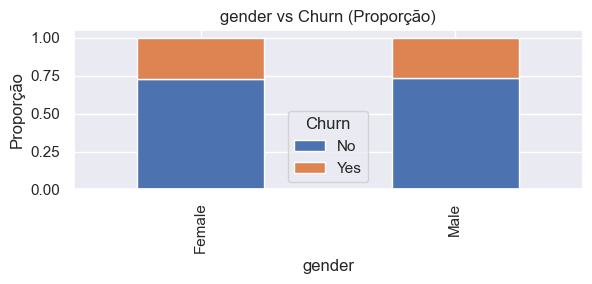

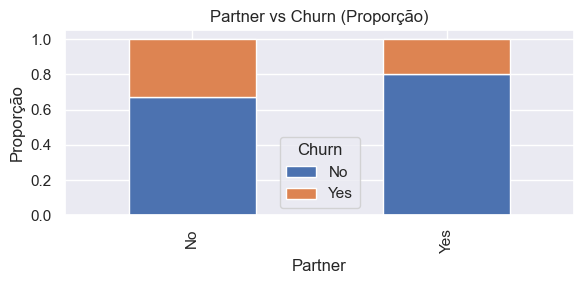

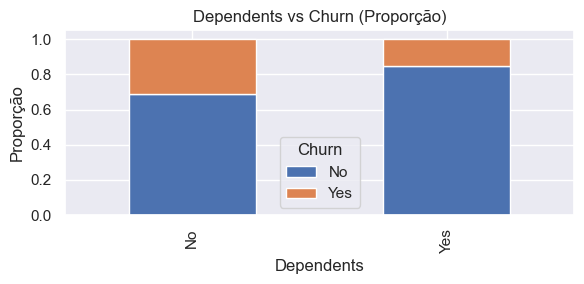

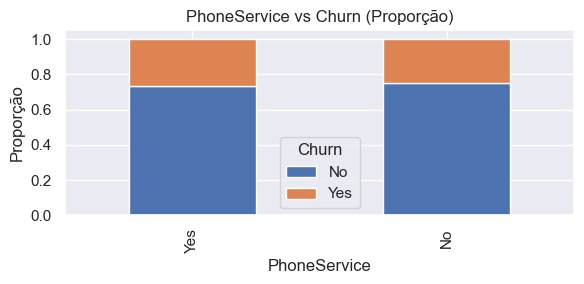

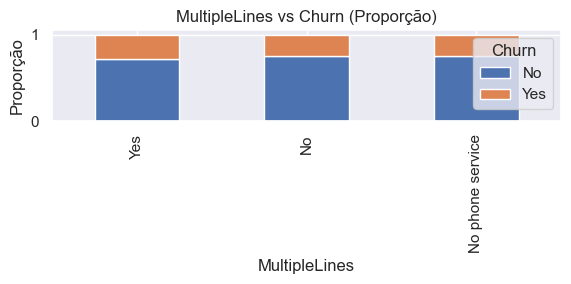

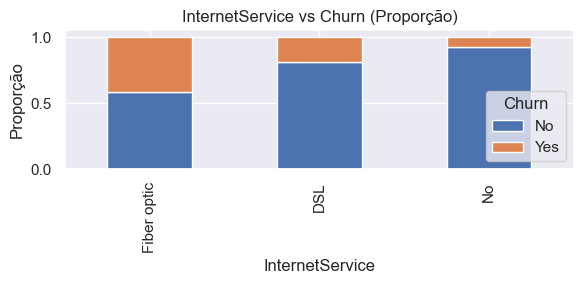

In [41]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categóricas: {len(cat_cols)} | Numéricas: {len(num_cols)}")

for col in cat_cols[:6]:
    prop = pd.crosstab(X[col], y, normalize='index').rename(columns={0:"No",1:"Yes"})
    prop.sort_values("Yes", ascending=False).plot(kind="bar", stacked=True, figsize=(6,3))
    plt.title(f"{col} vs Churn (Proporção)")
    plt.ylabel("Proporção")
    plt.tight_layout()
    plt.show()


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
y_train.mean(), y_test.mean()


(np.float64(0.2653532126375577), np.float64(0.2654364797728886))

In [43]:
num_transformer = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_transformer = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)


In [44]:
log_reg = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)

clf_log = Pipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", log_reg)
])
clf_log


,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
log_reg = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)

In [46]:
clf_log = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", log_reg),
])

clf_rf = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("model", rf),
])

# checagens de sanidade
import imblearn
assert isinstance(clf_log, imblearn.pipeline.Pipeline)
print(clf_log)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                 

=== Logistic Regression + SMOTE ===
              precision    recall  f1-score   support

           0     0.9060    0.7169    0.8004      1035
           1     0.5034    0.7941    0.6162       374

    accuracy                         0.7374      1409
   macro avg     0.7047    0.7555    0.7083      1409
weighted avg     0.7991    0.7374    0.7515      1409

ROC AUC: 0.84
Confusion Matrix:
 [[742 293]
 [ 77 297]]


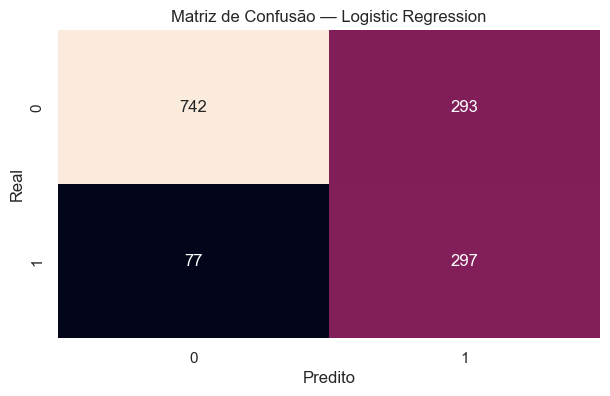

In [ ]:
auc_log = roc_auc_score(y_test, y_proba_log) # type: ignore

print("=== Logistic Regression + SMOTE ===")
print(classification_report(y_test, y_pred_log, digits=4)) # type: ignore
print("ROC AUC:", round(auc_log, 4)) 
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log)) # type: ignore

sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cbar=False) # type: ignore
plt.title("Matriz de Confusão — Logistic Regression")
plt.xlabel("Predito"); plt.ylabel("Real")
plt.show()
